두 가지 이슈가 있음. 

하나는 Train된 ResNet의 feature vector가 t-SNE로 기대처럼 안 모인다는 것. -- t-SNE 그릴 때 내가 label을 잘못 준 것일 수 있음 (loader에 shuffle이 내장되어있기 때문인듯?)
또 하나는, ResNet 자체가 1-channel에서 training이 되는지 잘 모르겠다는 점... 이 노트북에서는 일단 제대로 안 되는 것 같음. 
이미지에 문제가 있는 것 같지 않은데 왜 그럴까? layer별로 weight가 어떻게 변화하는지 모니터링이 필요할 듯. 

In [1]:
import argparse
import torch
import torch.backends.cudnn as cudnn
#from torchvision import models
from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
from models.resnet_simclr import ResNetSimCLR
from simclr import SimCLR

#model_names = sorted(name for name in models.__dict__
#                     if name.islower() and not name.startswith("__")
#                     and callable(models.__dict__[name]))

model_names = ['resnet18', 'resnet50']

import argparse 

args = argparse.Namespace()

args.data='./datasets' 
args.dataset_name='stl10'
args.arch='resnet50'
args.workers=1
args.epochs=300 
args.batch_size=256 
args.lr=0.02
args.wd=0.0005
args.disable_cuda=False
args.fp16_precision=True
args.out_dim=128
args.log_every_n_steps=100
args.temperature=0.07
args.n_views = 2
args.gpu_index=0
args.device='cuda' if torch.cuda.is_available() else 'cpu'
args.weight_decay=1e-4

print("Using device:", args.device)

Using device: cuda


In [2]:
# check if gpu training is available
if not args.disable_cuda and torch.cuda.is_available():
    args.device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    args.device = torch.device('cpu')
    args.gpu_index = -1

dataset = ContrastiveLearningDataset(args.data)

train_dataset = dataset.get_dataset(args.dataset_name, args.n_views)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, drop_last=True)

model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

Files already downloaded and verified


In [3]:
model

ResNetSimCLR(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

Validate 1-channel input

In [4]:
import matplotlib.pyplot as plt 

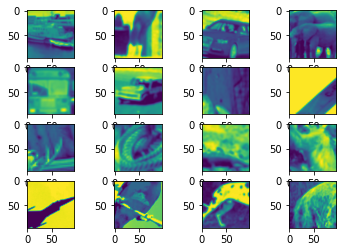

In [5]:
from tqdm import tqdm
from torch.cuda.amp import autocast
feature_arr = []
#for images, _ in tqdm(train_loader):
#    images = torch.cat(images, dim=0)
images, _ = next(iter(train_loader))
images = torch.cat(images, dim=0)
    
    
fig, axs = plt.subplots(4,4)
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.imshow(images[i][0])


In [6]:
def print_img_spec(img):
    print("min, max, mean:", img.min(), img.max(), img.mean())


print("averaged image")
print_img_spec(images[0])

averaged image
min, max, mean: tensor(0.0549) tensor(0.8837) tensor(0.4085)


1. 이미지 load에 한 세월? transform이 이상한 짓을 하고있나.. 
2. Training이 진행되지 않음... -- loss가 계속 7. 이미지 안 이상한데... 더 단순한 네트워크 (알렉스넷)으로 해봐야할까? 



In [7]:
optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                       last_epoch=-1)

#  It’s a no-op if the 'gpu_index' argument is a negative integer or None.
with torch.cuda.device(args.gpu_index):
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr.train(train_loader)

  0%|          | 0/390 [00:00<?, ?it/s]/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 87%|████████▋ | 339/390 [04:50<00:43,  1.17it/s]


KeyboardInterrupt: 